In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd 
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sbn 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import statsmodels.api as sm
from patsy import dmatrices

import sys
sys.path.append('./src/')
%aimport lib

In [2]:
class EFM_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        #self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.data = ['./data/HER2_EFM192A_data_v2/']
        self.drug = ['neratinib']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [2]
        self.batch_correct = [True]

class EFM_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        #self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.data = ['./data/HER2_EFM192A_data_v2/']
        self.drug = ['trastuzumab']
        self.resample_sz = [100]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]
        self.batch_correct = [True]

class SKB_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_04-07-22/']
        self.drug = ['neratinib']
        self.resample_sz = [100]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [0]
        self.batch_correct = [True]

class SKB_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_04-07-22/']
        self.drug = ['trastuzumab']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]
        self.batch_correct = [True]


In [3]:
## USE this to choose the experiment arguments - modify cell above to change

args = SKB_neratinib()
#args = SKB_trastuzumab()

#args = EFM_neratinib()
#args = EFM_trastuzumab()

In [4]:
data, clover_sel, mscarl_sel = lib.load_data(args)
data.head()


loading data...
# of datasets to load: 13


,track_index,0_x,15_x,30_x,45_x,60_x,75_x,90_x,105_x,120_x,...,2805_y,2820_y,2835_y,2850_y,2865_y,2880_y,2895_y,drug,cell_line,mutant
0,79_1000188375_skbr3_erk_akt__wt_untreated,0.235619,0.297726,0.351605,0.370527,0.421601,0.465694,0.465734,0.585255,0.588390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
1,3_1000012495_skbr3_erk_akt__wt_untreated,0.253752,0.315858,0.397225,0.414338,0.415737,0.424185,0.413190,0.362271,0.359833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
2,79_1000188229_skbr3_erk_akt__wt_untreated,0.352800,0.414907,0.468786,0.491494,0.589056,0.601831,0.564110,0.535816,0.727268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
3,1_1000003862_skbr3_erk_akt__wt_untreated,0.708865,0.677009,0.788085,0.801157,0.711717,0.663765,0.697446,0.669145,0.703938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
4,3_1000012346_skbr3_erk_akt__wt_untreated,0.514999,0.662859,0.596624,0.551089,0.594912,0.503896,0.545879,0.767552,0.665582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT


In [5]:
data, clover_sel, mscarl_sel = lib.filter_data(args, data, clover_sel, mscarl_sel)


filtering to drug and removing NAs...
drug id: neratinib
Data shape (untreated + drug): (23714, 398)
length of time series BEFORE removing time points with NA 150
length of time series AFTER removing time points with NA 135


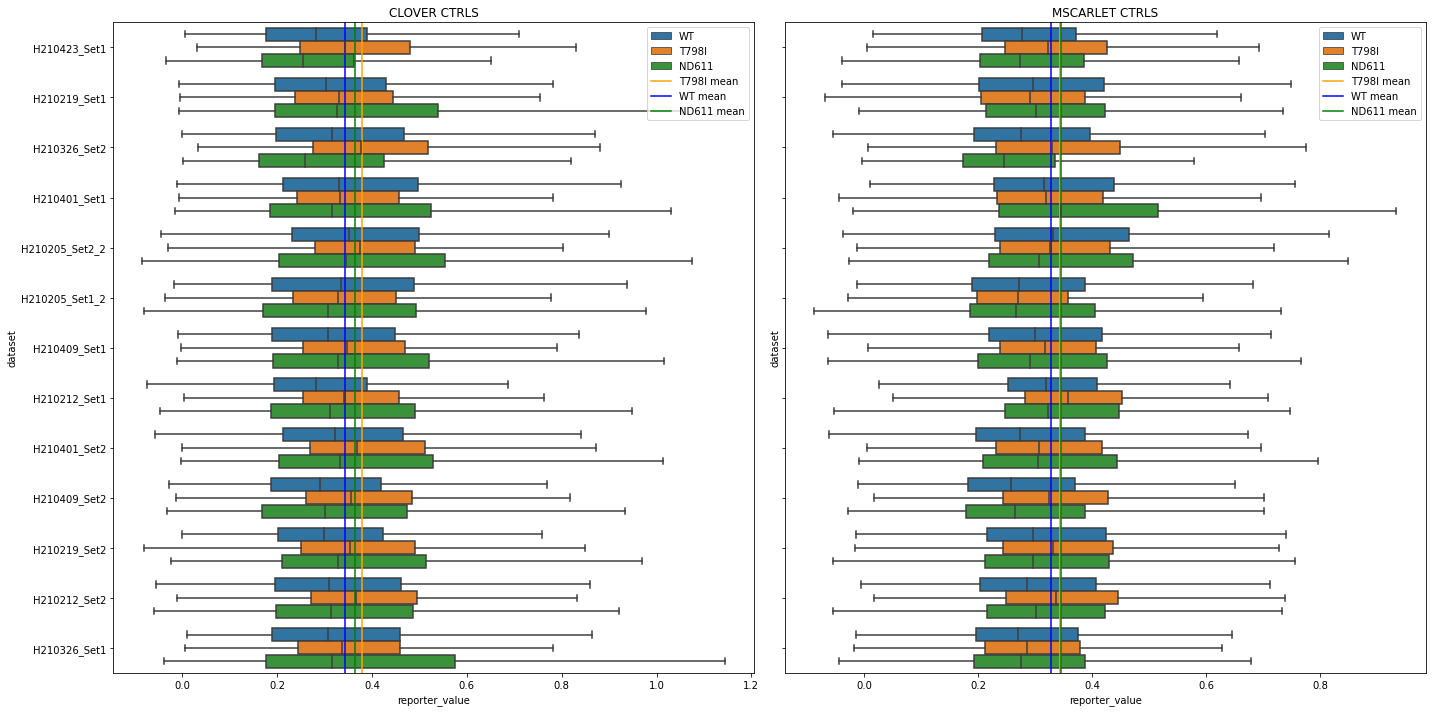

In [8]:
data_ctrls = lib.plot_reporter_batch_effects(data, args, clover_sel, mscarl_sel, save=None)

# BURN IN

In [9]:
# add burnin 
clover_sel = clover_sel[args.burnin[0]:]
mscarl_sel = mscarl_sel[args.burnin[0]:]

In [10]:
X_train = lib.resample(args, data, clover_sel, mscarl_sel)



resampling time series...
Training data shape BEFORE resampling: (23714, 135, 2)
Training data shape AFTER resampling: (23714, 100, 2)



performing time-series kmeans clustering...

4.105 --> 3.126 --> 3.061 --> 3.036 --> 3.021 --> 3.012 --> 3.006 --> 3.002 --> 2.999 --> 2.997 --> 2.995 --> 2.993 --> 2.992 --> 2.991 --> 2.990 --> 2.989 --> 2.988 --> 2.988 --> 2.987 --> 2.987 --> 2.986 --> 2.986 --> 2.985 --> 2.985 --> 2.984 --> 2.984 --> 2.983 --> 2.983 --> 2.982 --> 2.982 --> 2.982 --> 2.981 --> 2.981 --> 2.981 --> 2.981 --> 2.981 --> 2.981 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 2.980 --> 
plotting...


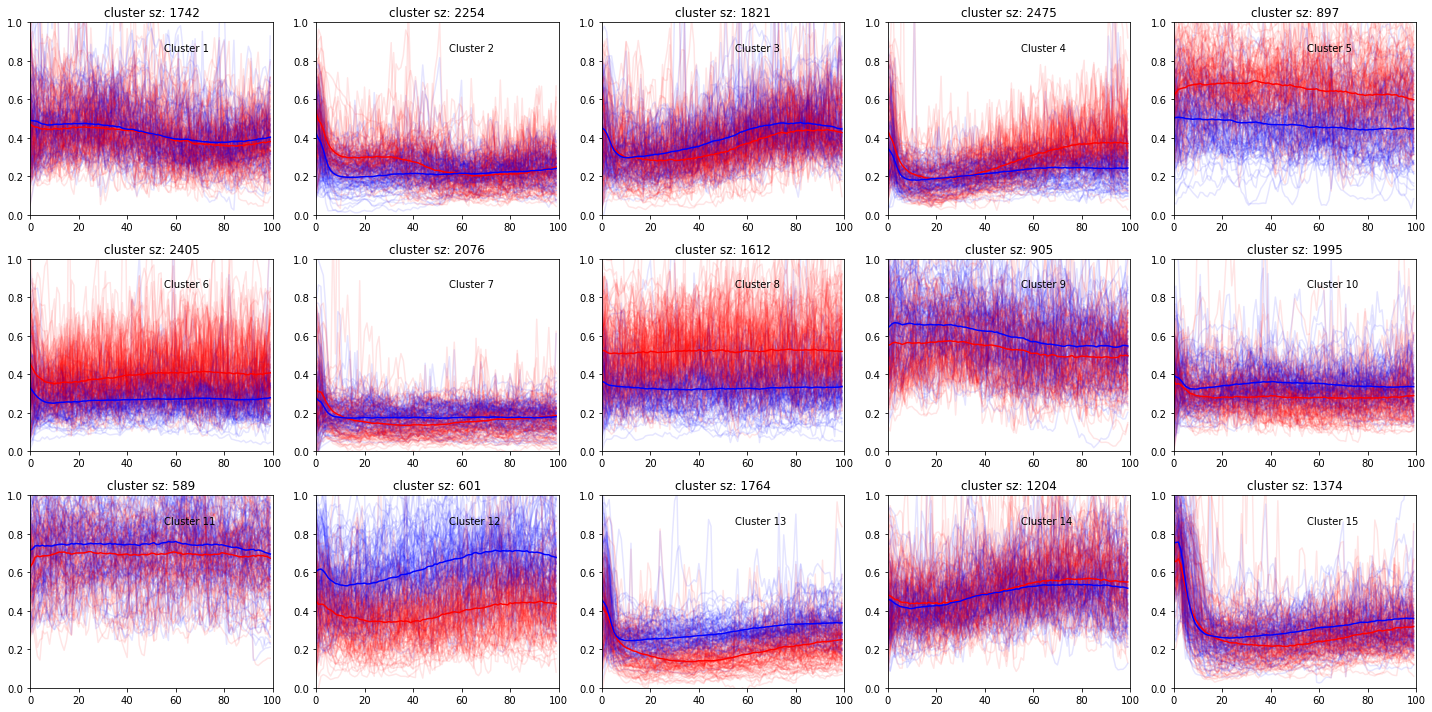

In [11]:
y_pred, km = lib.fit_kmeans(args, X_train, save=None)

In [12]:
cm, lb = lib.calc_cluster_proportions(args, y_pred, data)


quantifying experiment by cluster proportions...


<Figure size 504x504 with 0 Axes>

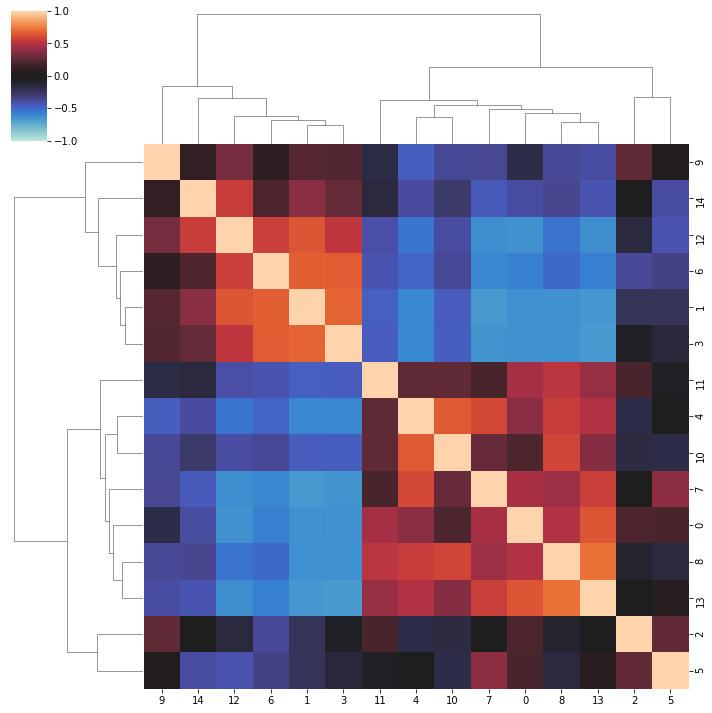

In [13]:
lib.plot_cluster_corr(cm, save=None)


performing dim. reduction (pca)...
PCA explained variance ratio: [0.5027174  0.12892321]
PC shape: (252, 2)


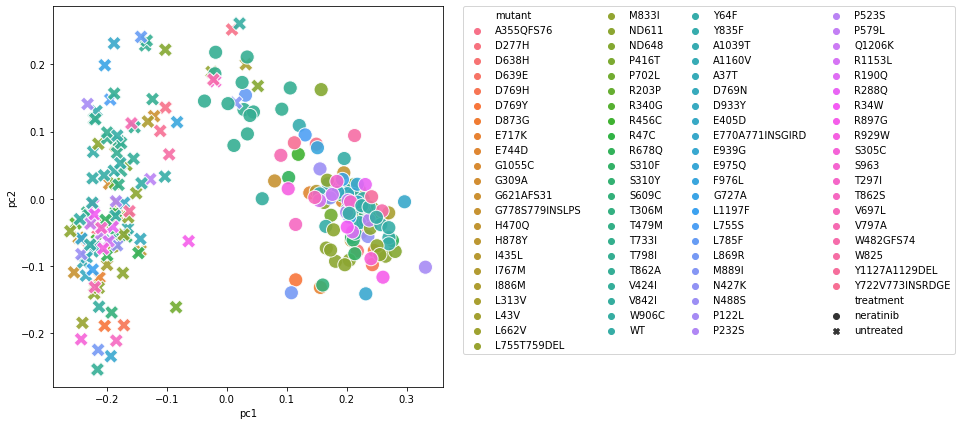

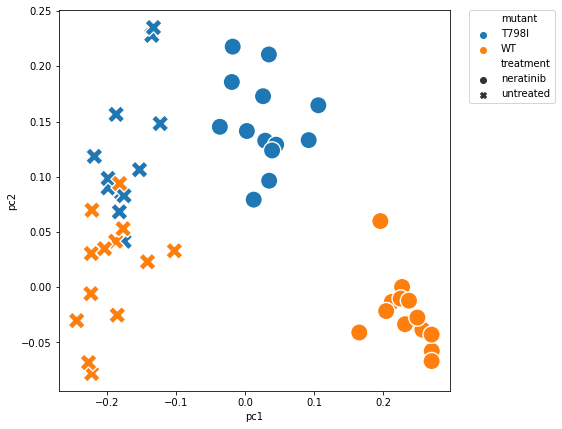

In [14]:
pca, res, _sens, _res, _drug = lib.dimensionality_reduction(args, cm, lb, save=None)

# PCA plot by mutation position

[1:37 PM] Samuel Tsang
the first letter is wild-type amino acid 

[1:37 PM] Samuel Tsang
number is the position

[1:37 PM] Samuel Tsang
right is the mutated amino acid

[1:38 PM] Samuel Tsang
so you can just grab the first set of numbers to call the position

[1:39 PM] Nathaniel Evans
what about the mutants with long names?

[1:43 PM] Samuel Tsang
It means the mutation change A @ pos 335 to Q, but also introduce frameshift (FS) and to create a new peptide sequence for 76 amino acid more

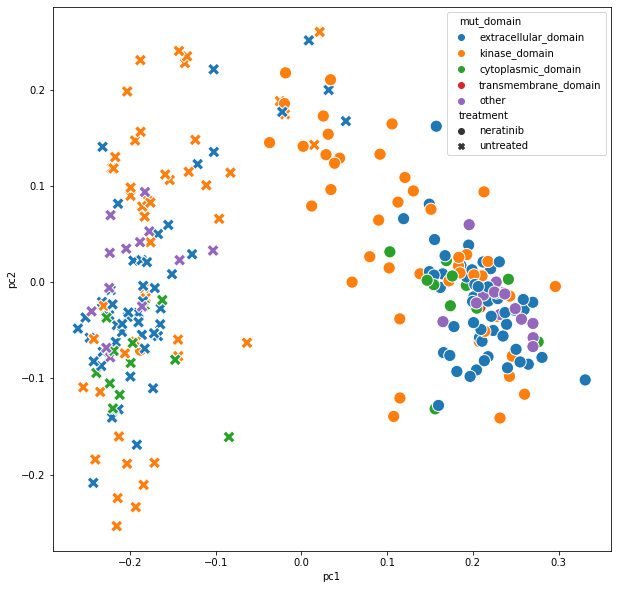

In [27]:
def parse_pos(mutant): 
    m='WT,Y722V773INSRDGE,ND648,ND611,T798I,T479M,G727A,Q1206K,E405D,P523S,R678Q,P702L,A1039T,I435L,A37T,V842I,N488S,L313V,R47C,D639E,L785F,T733I,R203P,E744D,V424I,R340G,D933Y,A1160V,I767M,P122L,V697L,P579L,R456C,E717K,G778_P780dup,L869R,Y64F,L755S,R929W,R288Q,E975Q,I886M,S310Y,R1153L,L1197F,R34W,F976L,M889I,T862S,S305C,T306M,P416T,N427K,D769H,T862A,H878Y,L43V,H470Q,E939G,D277H,W906C,R897G,S310F,Y835F,V777L,P232S,D769N,L662V,V797A,R190Q,T297I,S609C,D873G,G309A,D769Y,M833I,D638H,G1055C,Nd611,W482GFS74,A355QFS76,G621AFS31,Nd648,L755T759DEL,E770A771INSGIRD,Y772A775DUP,Y772V773INSRDGE,G778S779INSLPS,G778S779INSLPG,G778P780DUP,W825,S963,Y1127A1129DEL'
    p='-1,722,648,611,798,479,727,1206,405,523,678,702,1039,435,37,842,488,313,47,639,785,733,203,744,424,340,933,1160,767,122,697,579,456,717,778,869,64,755,929,288,975,886,310,1153,1197,34,976,889,862,305,306,416,427,769,862,878,43,470,939,277,906,897,310,835,777,232,769,662,797,190,297,609,873,309,769,833,638,1055,611,482,355,621,648,755,770,772,772,778,778,778,825,963,1127'
    mp = {mm:pp for mm,pp in zip(m.split(','), p.split(','))}

    try: 
        return int(mp[mutant])
    except: 
        print(mutant)

res_pos = res.assign(mut_pos = [parse_pos(x) for x in res.mutant.values])
#res_pos = res_pos[lambda x: x.mutant !='WT']

def assign_to_domain(pos): 
    if (pos >= 22) and (pos <= 653): 
        return 'extracellular_domain'
    elif (pos >= 720) and (pos <= 987): 
        return 'kinase_domain'
    elif (pos >= 654) and (pos <= 675): 
        return 'transmembrane_domain' 
    elif (pos >= 676) and (pos <= 1255): 
        return 'cytoplasmic_domain'
    else:
        return 'other'

res_pos = res_pos.assign(mut_domain = [assign_to_domain(x) for x in res_pos.mut_pos.values])

plt.figure(figsize=(10,10))
#[lambda x: x.treatment == 'untreated']
sbn.scatterplot(x='pc1', y='pc2', hue='mut_domain', data=res_pos, s=150, linewidth=1, alpha=1, style='treatment')
plt.show()

In [26]:
res_pos.mut_domain.unique()

array(['extracellular_domain', 'kinase_domain', 'cytoplasmic_domain',
       'transmembrane_domain', 'other'], dtype=object)

In [ ]:

plt.figure()
#sbn.scatterplot(x='pc1', y='mut_pos', data=res_pos, s=150, linewidth=0, alpha=0.75, style='treatment')
sbn.regplot(x='pc1', y='mut_pos', data=res_pos)
plt.show() 

f, axes = plt.subplots(1,2,figsize=(10,5))
sbn.regplot(x='pc1', y='mut_pos', data=res_pos[lambda x: x.treatment != 'untreated'], ax=axes[0])
sbn.regplot(x='pc1', y='mut_pos', data=res_pos[lambda x: x.treatment == 'untreated'], ax=axes[1])
plt.show()

plt.figure()
#sbn.scatterplot(x='pc2', y='mut_pos', data=res_pos, s=150, linewidth=0, alpha=0.75, style='treatment')
sbn.regplot(x='pc2', y='mut_pos', data=res_pos)
plt.show() 

f, axes = plt.subplots(1,2,figsize=(10,5))
sbn.regplot(x='pc2', y='mut_pos', data=res_pos[lambda x: x.treatment != 'untreated'], ax=axes[0])
sbn.regplot(x='pc2', y='mut_pos', data=res_pos[lambda x: x.treatment == 'untreated'], ax=axes[1])
plt.show()


plt.figure(figsize=(10,10))
sbn.scatterplot(x='pc1', y='pc2', hue='mut_pos', data=res_pos, s=150, linewidth=0, alpha=1, style='treatment')
plt.show()

# Add the `cell counts`

In [65]:
cell_cnts = data.groupby(['mutant', 'drug', 'dataset'])['track_index'].count().reset_index().rename({'track_index':'cell_count'}, axis=1).assign(dataset=lambda x: x.dataset.str.upper())
res = res.merge(cell_cnts, left_on=['mutant', 'treatment', 'batch'], right_on=['mutant', 'drug', 'dataset'], how='left', validate='1:1').drop(['drug', 'dataset'], axis=1)
res

,pc1,pc2,treatment,mutant,batch,cell_count
0,0.152732,0.112122,neratinib,A355QFS76,H210205_SET2_2,134
1,-0.087807,0.136216,untreated,A355QFS76,H210205_SET2_2,87
2,0.260940,-0.044332,neratinib,A355QFS76,H210423_SET1,56
3,0.008469,0.247056,untreated,A355QFS76,H210423_SET1,41
4,0.200152,-0.077288,neratinib,D277H,H210219_SET1,309
...,...,...,...,...,...,...
247,-0.157106,0.074849,untreated,WT,H210423_SET1,63
248,0.237320,0.025632,neratinib,Y1127A1129DEL,H210401_SET2,116
249,-0.151635,-0.015398,untreated,Y1127A1129DEL,H210401_SET2,88
250,0.100457,0.090108,neratinib,Y722V773INSRDGE,H210401_SET1,58


# Review the batches that each mutant appear in 

Is this as expected? 

In [66]:
batch_cnts = res.groupby(['mutant', 'treatment'])['batch'].unique().reset_index().assign(n_uniq = lambda y: [len(x) for x in y.batch]).sort_values('n_uniq')
batch_cnts[lambda x: x.n_uniq > 1]

,mutant,treatment,batch,n_uniq
4,A355QFS76,neratinib,"[H210205_SET2_2, H210423_SET1]",2
5,A355QFS76,untreated,"[H210205_SET2_2, H210423_SET1]",2
124,S310F,neratinib,"[H210423_SET1, H210326_SET2]",2
152,V842I,neratinib,"[H210205_SET2_2, H210423_SET1]",2
125,S310F,untreated,"[H210423_SET1, H210326_SET2]",2
117,R678Q,untreated,"[H210205_SET2_2, H210423_SET1]",2
116,R678Q,neratinib,"[H210205_SET2_2, H210423_SET1]",2
85,ND648,untreated,"[H210205_SET2_2, H210205_SET1_2]",2
153,V842I,untreated,"[H210205_SET2_2, H210423_SET1]",2
84,ND648,neratinib,"[H210205_SET2_2, H210205_SET1_2]",2


# Visualize batch effects 

(then we'll check and correct)

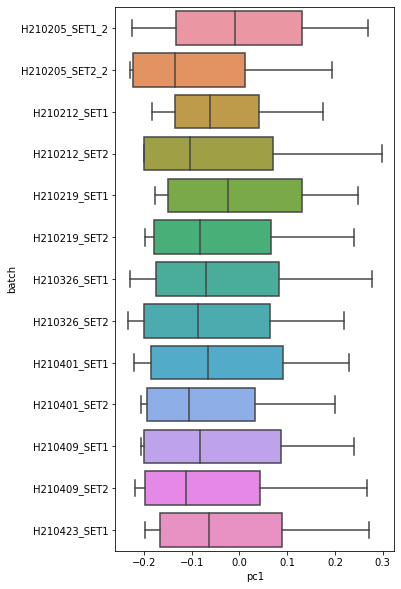

In [67]:
plt.figure(figsize=(5, 10)) 
sbn.boxplot(y='batch', x='pc1', data=res[lambda x: (x.mutant.isin([args.resistant_line[0], args.sensitive_line[0]]))])
plt.show()

# Test for batch effects 

We do this by running a regression based on batch (filtered to controls). 

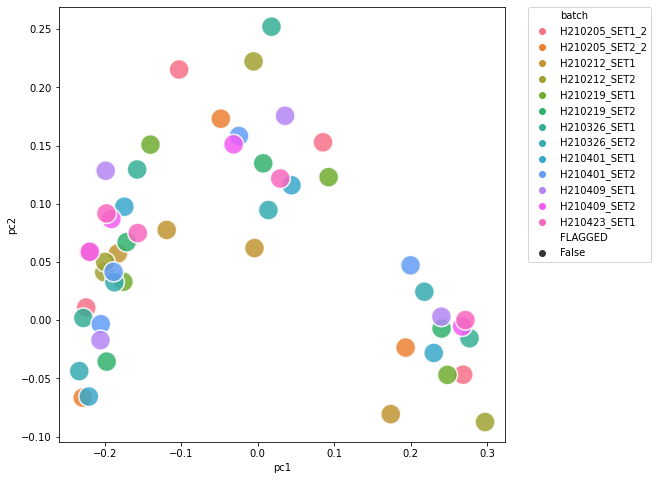

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210205_SET1_2,0.035197,0.726458,0.030485,0.492282,dummy_id
1,H210205_SET2_2,-0.047822,0.634782,-0.017188,0.698038,dummy_id
2,H210212_SET1,-0.004660,0.963026,-0.023545,0.595419,dummy_id
3,H210212_SET2,0.001285,0.989800,0.003942,0.929025,dummy_id
4,H210219_SET1,0.034662,0.730445,0.012368,0.780013,dummy_id


In [68]:
batch_res = lib.get_batch_effects(args, res, 'dummy_id', save=None)
batch_res.head()

# Batch Correction 

Subtract the regression coeficient for each batch (e.g., PCx controls mean by batch) from mutant PCx values. 

In [69]:
if args.batch_correct[0]: 
    res_unadjusted = res.assign(pc1_uncor=None, pc2_uncor=None)
    res = lib.batch_correction(res, batch_res)
else: 
    print('not performing batch corrections!')
    res = res.assign(pc1_uncor=None, pc2_uncor=None)
    res_unadjusted = res

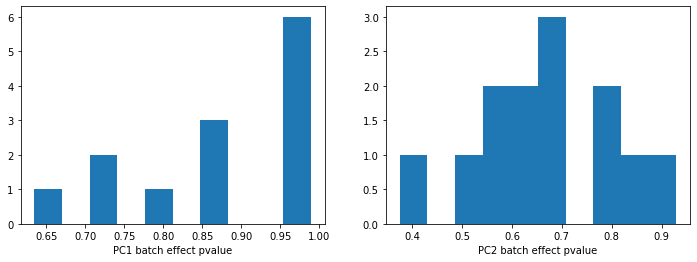

In [70]:
f,axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(batch_res.pc1_pval, bins=10)
axes[0].set_xlabel('PC1 batch effect pvalue')
axes[1].hist(batch_res.pc2_pval, bins=10)
axes[1].set_xlabel('PC2 batch effect pvalue')
plt.show()

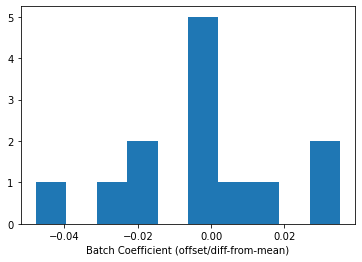

In [71]:
# batch effect sizes 

# large values (> 0.1-0.2) indicate a significant effect size 

plt.figure() 
plt.hist(batch_res.pc1_coef)
plt.xlabel('Batch Coefficient (offset/diff-from-mean)')
plt.show()

# Finally, train classifier - predict mutant resistance/sensitivity


training classifier...
sensitive line: WT
resistant line: T798I
drug: neratinib
drug + WT df size:  (26, 13)
X train shape: (26, 2)
# neg class (resistant): 13
# pos class (sensitive): 13


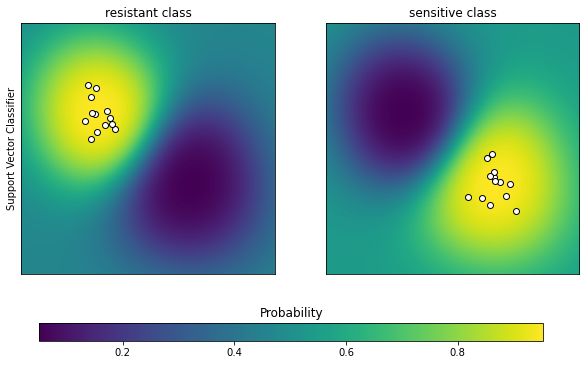


Training accuracy: 100.0%


In [72]:
model, accuracy = lib.train_classifier(res, _sens, _res, _drug, save=None)
print()
print(f'Training accuracy: {accuracy*100}%')

In [73]:
prob_res = lib.predict_new(args, res, model)
prob_res.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
0,0.200554,0.129310,neratinib,A355QFS76,H210205_SET2_2,134,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.152732,0.112122,0.336380,0.663620,sens
1,0.209194,0.047406,neratinib,D639E,H210205_SET2_2,180,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.161372,0.030218,0.106108,0.893892,sens
2,0.209906,-0.001666,neratinib,ND611,H210205_SET2_2,75,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.162084,-0.018854,0.063570,0.936430,sens
3,0.203684,0.271064,neratinib,ND648,H210205_SET2_2,66,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.155863,0.253876,0.530574,0.469426,res
4,0.126409,0.074809,neratinib,R678Q,H210205_SET2_2,274,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.078587,0.057621,0.594427,0.405573,res


In [74]:
prob_res.sort_values('prob_res', ascending=False).head()

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
46,0.009062,0.147525,neratinib,T798I,H210219_SET2,86,-0.001937,0.984626,-0.012785,0.772799,dummy_id,0.007124,0.134739,0.949197,0.050803,res
104,0.001532,0.149942,neratinib,T798I,H210401_SET2,94,-0.026232,0.794225,0.008309,0.851117,dummy_id,-0.024700,0.158251,0.947978,0.052022,res
84,0.039465,0.155670,neratinib,T798I,H210409_SET1,90,-0.003735,0.970363,0.019915,0.653157,dummy_id,0.035730,0.175585,0.945990,0.054010,res
122,0.045971,0.138561,neratinib,T798I,H210401_SET1,102,-0.001819,0.985567,-0.022645,0.609509,dummy_id,0.044153,0.115916,0.941568,0.058432,res
75,0.032774,0.120175,neratinib,T798I,H210326_SET2,45,-0.018874,0.851108,-0.025585,0.564065,dummy_id,0.013900,0.094591,0.941054,0.058946,res


# How does batch effect correction change our results? 


In [75]:
res.head()

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id,pc1_uncor,pc2_uncor
0,0.200554,0.129310,neratinib,A355QFS76,H210205_SET2_2,134,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.152732,0.112122
1,-0.039985,0.153404,untreated,A355QFS76,H210205_SET2_2,87,-0.047822,0.634782,-0.017188,0.698038,dummy_id,-0.087807,0.136216
2,0.209194,0.047406,neratinib,D639E,H210205_SET2_2,180,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.161372,0.030218
3,-0.181680,-0.008811,untreated,D639E,H210205_SET2_2,104,-0.047822,0.634782,-0.017188,0.698038,dummy_id,-0.229502,-0.025999
4,0.209906,-0.001666,neratinib,ND611,H210205_SET2_2,75,-0.047822,0.634782,-0.017188,0.698038,dummy_id,0.162084,-0.018854


In [76]:
res_unadjusted.head()

,pc1,pc2,treatment,mutant,batch,cell_count,pc1_uncor,pc2_uncor
0,0.152732,0.112122,neratinib,A355QFS76,H210205_SET2_2,134,None,None
1,-0.087807,0.136216,untreated,A355QFS76,H210205_SET2_2,87,None,None
2,0.260940,-0.044332,neratinib,A355QFS76,H210423_SET1,56,None,None
3,0.008469,0.247056,untreated,A355QFS76,H210423_SET1,41,None,None
4,0.200152,-0.077288,neratinib,D277H,H210219_SET1,309,None,None


In [77]:
prob_res_uncor = lib.predict_new(args, res_unadjusted, model)
prob_res_uncor.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,batch,cell_count,pc1_uncor,pc2_uncor,prob_res,prob_sens,call
0,0.152732,0.112122,neratinib,A355QFS76,H210205_SET2_2,134,None,None,0.558634,0.441366,res
1,0.260940,-0.044332,neratinib,A355QFS76,H210423_SET1,56,None,None,0.048588,0.951412,sens
2,0.200152,-0.077288,neratinib,D277H,H210219_SET1,309,None,None,0.068904,0.931096,sens
3,0.226502,-0.079165,neratinib,D638H,H210219_SET1,173,None,None,0.059637,0.940363,sens
4,0.161372,0.030218,neratinib,D639E,H210205_SET2_2,180,None,None,0.202515,0.797485,sens


In [78]:
comp = prob_res[['mutant', 'prob_res', 'batch']].merge(prob_res_uncor[['mutant', 'prob_res', 'batch']], on=['mutant', 'batch']).assign(delta=lambda x: x.prob_res_x - x.prob_res_y)
comp.head()

,mutant,prob_res_x,batch,prob_res_y,delta
0,A355QFS76,0.336380,H210205_SET2_2,0.558634,-0.222255
1,D639E,0.106108,H210205_SET2_2,0.202515,-0.096407
2,ND611,0.063570,H210205_SET2_2,0.119730,-0.056160
3,ND648,0.530574,H210205_SET2_2,0.662668,-0.132095
4,R678Q,0.594427,H210205_SET2_2,0.783375,-0.188949


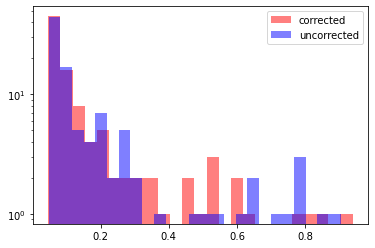

In [79]:
plt.figure()
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].prob_res_x, color='r', alpha=0.5, bins=25, label='corrected')
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].prob_res_y, color='b', alpha=0.5, bins=25, label='uncorrected')
plt.yscale('log')
plt.legend()
plt.show()

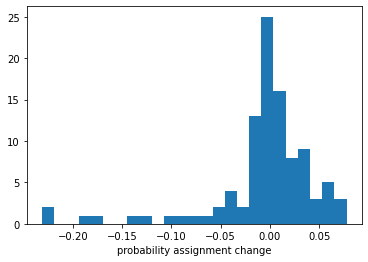

In [80]:
plt.figure()
plt.hist(comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].delta, bins=25)
plt.xlabel('probability assignment change')
plt.show()

In [81]:
# mutants with the most change
comp[lambda x: ~(x.mutant.isin([args.sensitive_line[0], args.resistant_line[0]]))].sort_values('delta', ascending=False)

,mutant,prob_res_x,batch,prob_res_y,delta
120,R929W,0.442604,H210401_SET1,0.364723,0.077881
107,E939G,0.201276,H210326_SET1,0.128412,0.072864
22,ND611,0.168769,H210219_SET1,0.103234,0.065535
113,S305C,0.176778,H210326_SET1,0.111346,0.065432
23,S609C,0.274730,H210219_SET1,0.212300,0.062429
...,...,...,...,...,...
7,V842I,0.591828,H210205_SET2_2,0.724801,-0.132972
92,L755S,0.486484,H210409_SET2,0.661956,-0.175472
4,R678Q,0.594427,H210205_SET2_2,0.783375,-0.188949
0,A355QFS76,0.336380,H210205_SET2_2,0.558634,-0.222255


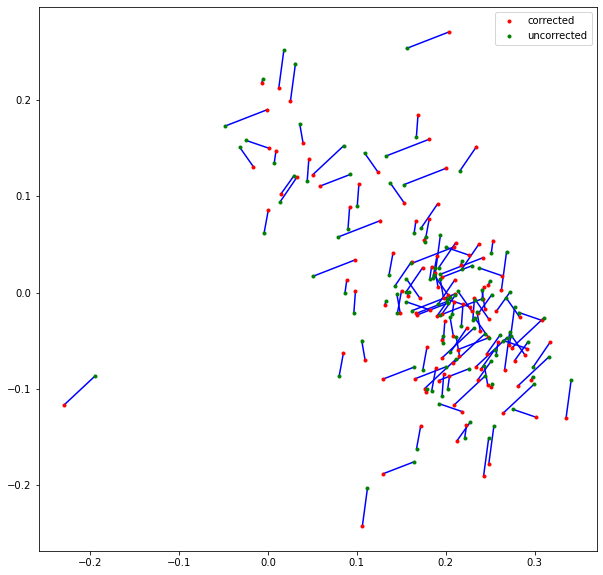

In [82]:
# how does batch effect correction change our results?

plt.figure(figsize=(10,10))
for i,row in prob_res.iterrows(): 
    plt.plot(row[['pc1_uncor', 'pc1']].values, row[['pc2_uncor', 'pc2']].values, 'b-')

plt.plot(prob_res['pc1'].values,prob_res['pc2'].values, 'r.', label='corrected')
plt.plot(prob_res['pc1_uncor'].values,prob_res['pc2_uncor'].values, 'g.', label='uncorrected')
plt.legend()
plt.show()